# Package

In [1]:
#
import numpy as np
# Pytorch
import torch
torch.set_num_threads(8)
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# # Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
#
import matplotlib.pyplot as plt
#
import gc

# Read dataset & Create Data

In [2]:
in_features = 20
out_features = 1

dataset = np.load("ML_Ubar_EMF_allmode.npz")
print("Original dataset shape: ", dataset["PC_Ubar"].shape, dataset["PC_EMF"].shape)

# Formatter
EMF_dataset = np.array(np.swapaxes(dataset["PC_EMF"], 0,1), dtype = "float32")
Ubar_dataset = np.array(np.swapaxes(dataset["PC_Ubar"], 0,1), dtype = "float32")

# Feature selection
input_dataset = EMF_dataset[:,:in_features]
output_dataset = Ubar_dataset[:,:out_features]
print("Formatted dataset shape: ", input_dataset.shape, output_dataset.shape)
del dataset
del EMF_dataset
del Ubar_dataset
_ = gc.collect()

Original dataset shape:  (640, 76000) (640, 76000)
Formatted dataset shape:  (76000, 20) (76000, 1)


Input dataset shape:  (75960, 20) (75960, 1)


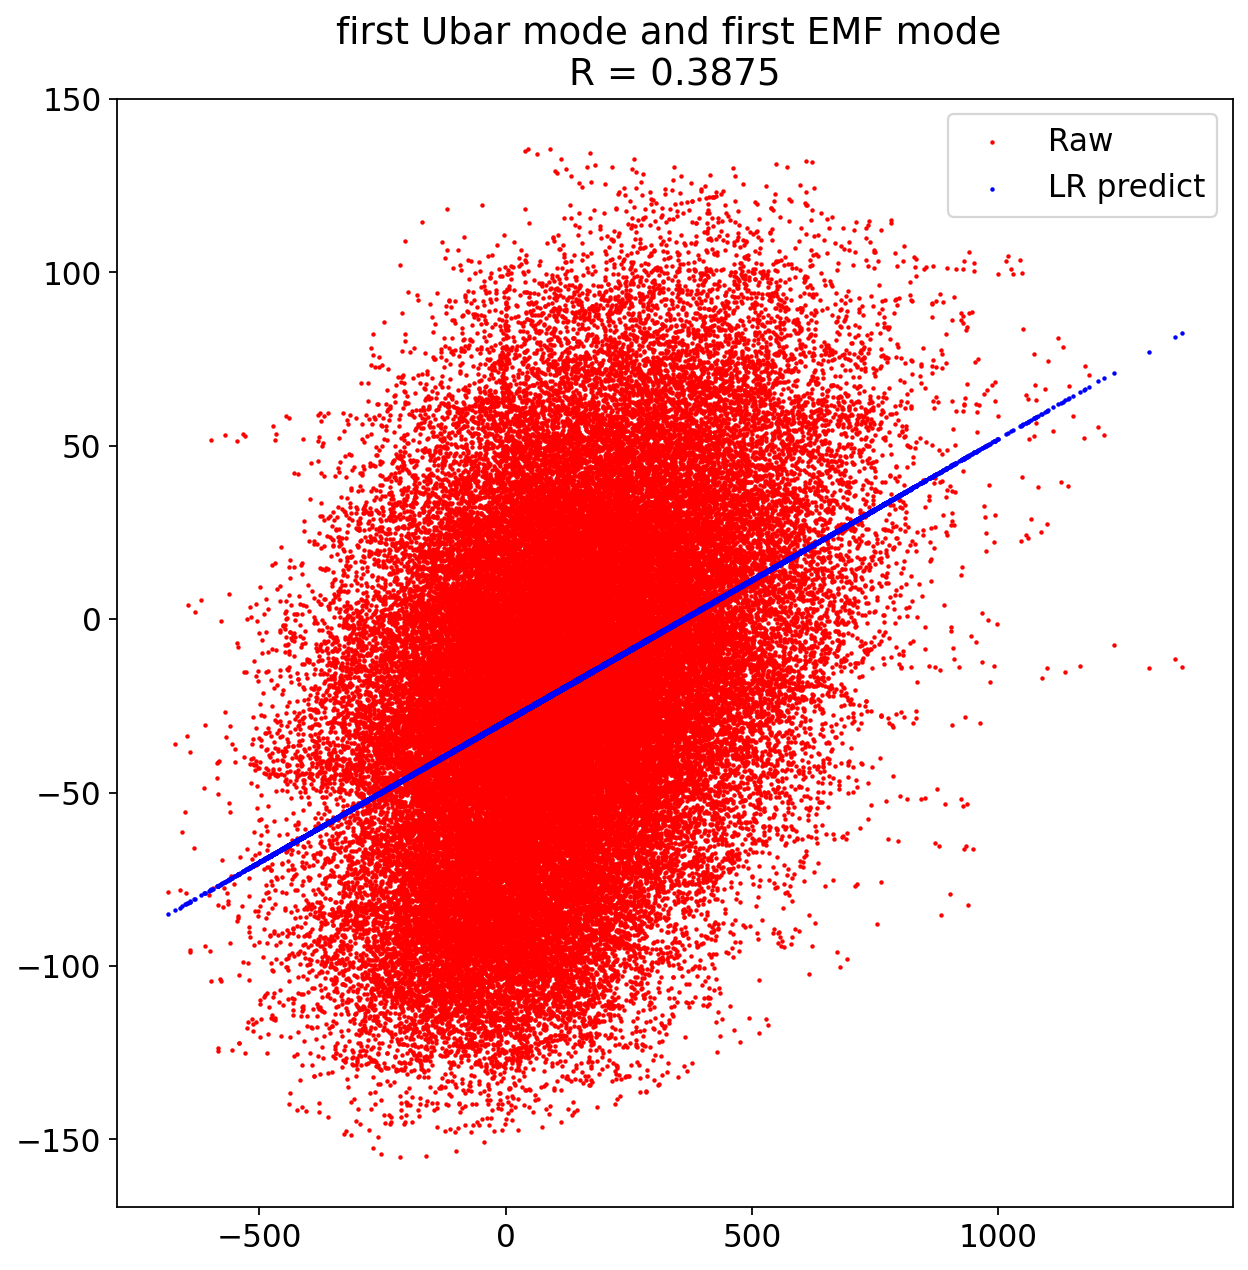

In [12]:
# Lag
lag_shift = 40
# Shuffle
random_shuffle_index = np.random.permutation(len(input_dataset)-lag_shift)

# Target
# Lead 1 prediction, AR(1)
ML_input = input_dataset[:-lag_shift,:][random_shuffle_index]
ML_output = output_dataset[lag_shift:,:][random_shuffle_index]

# Divide ratio
train_size = int(len(ML_input)*(12/16))
valid_size = int(len(ML_input)*(1/16))
test_size = len(ML_input) - train_size - valid_size


# Simple verification
print("Input dataset shape: ", ML_input.shape, ML_output.shape)
plt.figure(figsize = (9, 9), dpi = 160)
plt.rcParams.update({'font.size': 14})
tmp = LinearRegression().fit(ML_input[:,:1], ML_output[:,:1])
plt.scatter(ML_input[:,:1], ML_output[:,:1], label = "Raw", s = 1, color = "r")
plt.scatter(ML_input[:,:1], tmp.predict(ML_input[:,:1])[:,:1], label = "LR predict", s = 1, color = "b")
tmp = np.corrcoef(ML_input[:,0],  ML_output[:,0])[0,-1]
plt.legend()
plt.title(f"first Ubar mode and first EMF mode \nR = {tmp:4.4f}")




ML_input_train_set = ML_input[:train_size]
ML_input_valid_set = ML_input[train_size:train_size+valid_size]
ML_input_test_set = ML_input[train_size+valid_size:]
ML_output_train_set = ML_output[:train_size]
ML_output_valid_set = ML_output[train_size:train_size+valid_size]
ML_output_test_set = ML_output[train_size+valid_size:]

train_loader = DataLoader(TensorDataset(torch.from_numpy(ML_input_train_set[:]), torch.from_numpy(ML_output_train_set[:])),
                          batch_size = 256,
                          shuffle = True,
                          pin_memory = True)
valid_loader = DataLoader(TensorDataset(torch.from_numpy(ML_input_valid_set[:]), torch.from_numpy(ML_output_valid_set[:])),
                          batch_size = 256,
                          shuffle = False,
                          pin_memory = True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(ML_input_test_set[:]), torch.from_numpy(ML_output_test_set[:])),
                         batch_size = 256,
                         shuffle = False,
                         pin_memory = True)

In [5]:
class NonLinear_Model(nn.Module):
    def __init__(self, mean, std):
        super(NonLinear_Model, self).__init__()
        self.BN0 = nn.BatchNorm1d(num_features = in_features)
        self.fc1 = nn.Linear(in_features, 10)
        self.act1= nn.LeakyReLU()
        self.BN1 = nn.BatchNorm1d(num_features = 10)
        self.fc2 = nn.Linear(10, 10)
        self.act2= nn.LeakyReLU()
        self.BN2 = nn.BatchNorm1d(num_features = 10)
        self.fc3 = nn.Linear(10, out_features)
        
        self.mean = torch.from_numpy(mean)
        self.std = torch.from_numpy(std)
    def forward(self, x):
        out = (x-self.mean)/self.std
        out = self.BN0(out)
        out = self.BN1(self.act1(self.fc1(out)))
        out = self.BN2(self.act2(self.fc2(out)))
        out = self.fc3(out)
        return out

In [6]:
def Train_main(model, lr, wd, epochs, train_loader, valid_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = lr, 
                                 weight_decay = wd)
    criterion = nn.MSELoss(reduction='mean')
    mean_train_loss_record = []
    mean_valid_loss_record = []
    for epoch in range(epochs):
        model.train()
        loss_record = []
        for (x, y) in train_loader:
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat[:], y[:])
            loss.backward()
            optimizer.step()
            loss_record.append(loss.detach().item())
        mean_train_loss_record.append(sum(loss_record)/len(loss_record))
        model.eval()
        loss_record = []
        for (x, y) in valid_loader:
            with torch.no_grad():
                y_hat = model(x)
                loss = criterion(y_hat[:], y[:])
            loss_record.append(loss.item())
        mean_valid_loss_record.append(sum(loss_record)/len(loss_record))
        if (epoch%10==0):
                    print(f'Epoch [{epoch+1}]: Train loss: {mean_train_loss_record[-1]:.7f}, Valid loss: {mean_valid_loss_record[-1]:.7f}')
    return mean_train_loss_record, mean_valid_loss_record

In [7]:
regression = LinearRegression().fit(ML_input_train_set, ML_output_train_set)
model = NonLinear_Model(ML_input_train_set[:].mean(axis = 0, keepdims = True), ML_input_train_set[:].std(axis = 0, keepdims = True))
train_loss, valid_loss = Train_main(model, 1e-4, 1e0, 150, train_loader, valid_loader, test_loader)

Epoch [1]: Train loss: 2732.0858762, Valid loss: 2709.6668765
Epoch [11]: Train loss: 2314.0448108, Valid loss: 2281.8162135
Epoch [21]: Train loss: 1898.2618255, Valid loss: 1869.3676244
Epoch [31]: Train loss: 1507.2121828, Valid loss: 1471.9397808
Epoch [41]: Train loss: 1174.4947346, Valid loss: 1156.6356812
Epoch [51]: Train loss: 940.0442571, Valid loss: 936.8249833
Epoch [61]: Train loss: 828.6325829, Valid loss: 832.3586715
Epoch [71]: Train loss: 799.1616684, Valid loss: 802.9628296
Epoch [81]: Train loss: 793.3392651, Valid loss: 794.4371499
Epoch [91]: Train loss: 791.4621620, Valid loss: 791.3638049
Epoch [101]: Train loss: 787.4058471, Valid loss: 790.0764192
Epoch [111]: Train loss: 786.0906271, Valid loss: 785.3937603
Epoch [121]: Train loss: 782.7384583, Valid loss: 785.2984073
Epoch [131]: Train loss: 783.3615879, Valid loss: 782.3327348
Epoch [141]: Train loss: 779.9518011, Valid loss: 785.3396028


# Evaluate

In [8]:
model.eval()
pred_data = model(torch.from_numpy(ML_input_test_set)).detach().numpy()

Text(0.5, 1.0, 'MSELoss evolution')

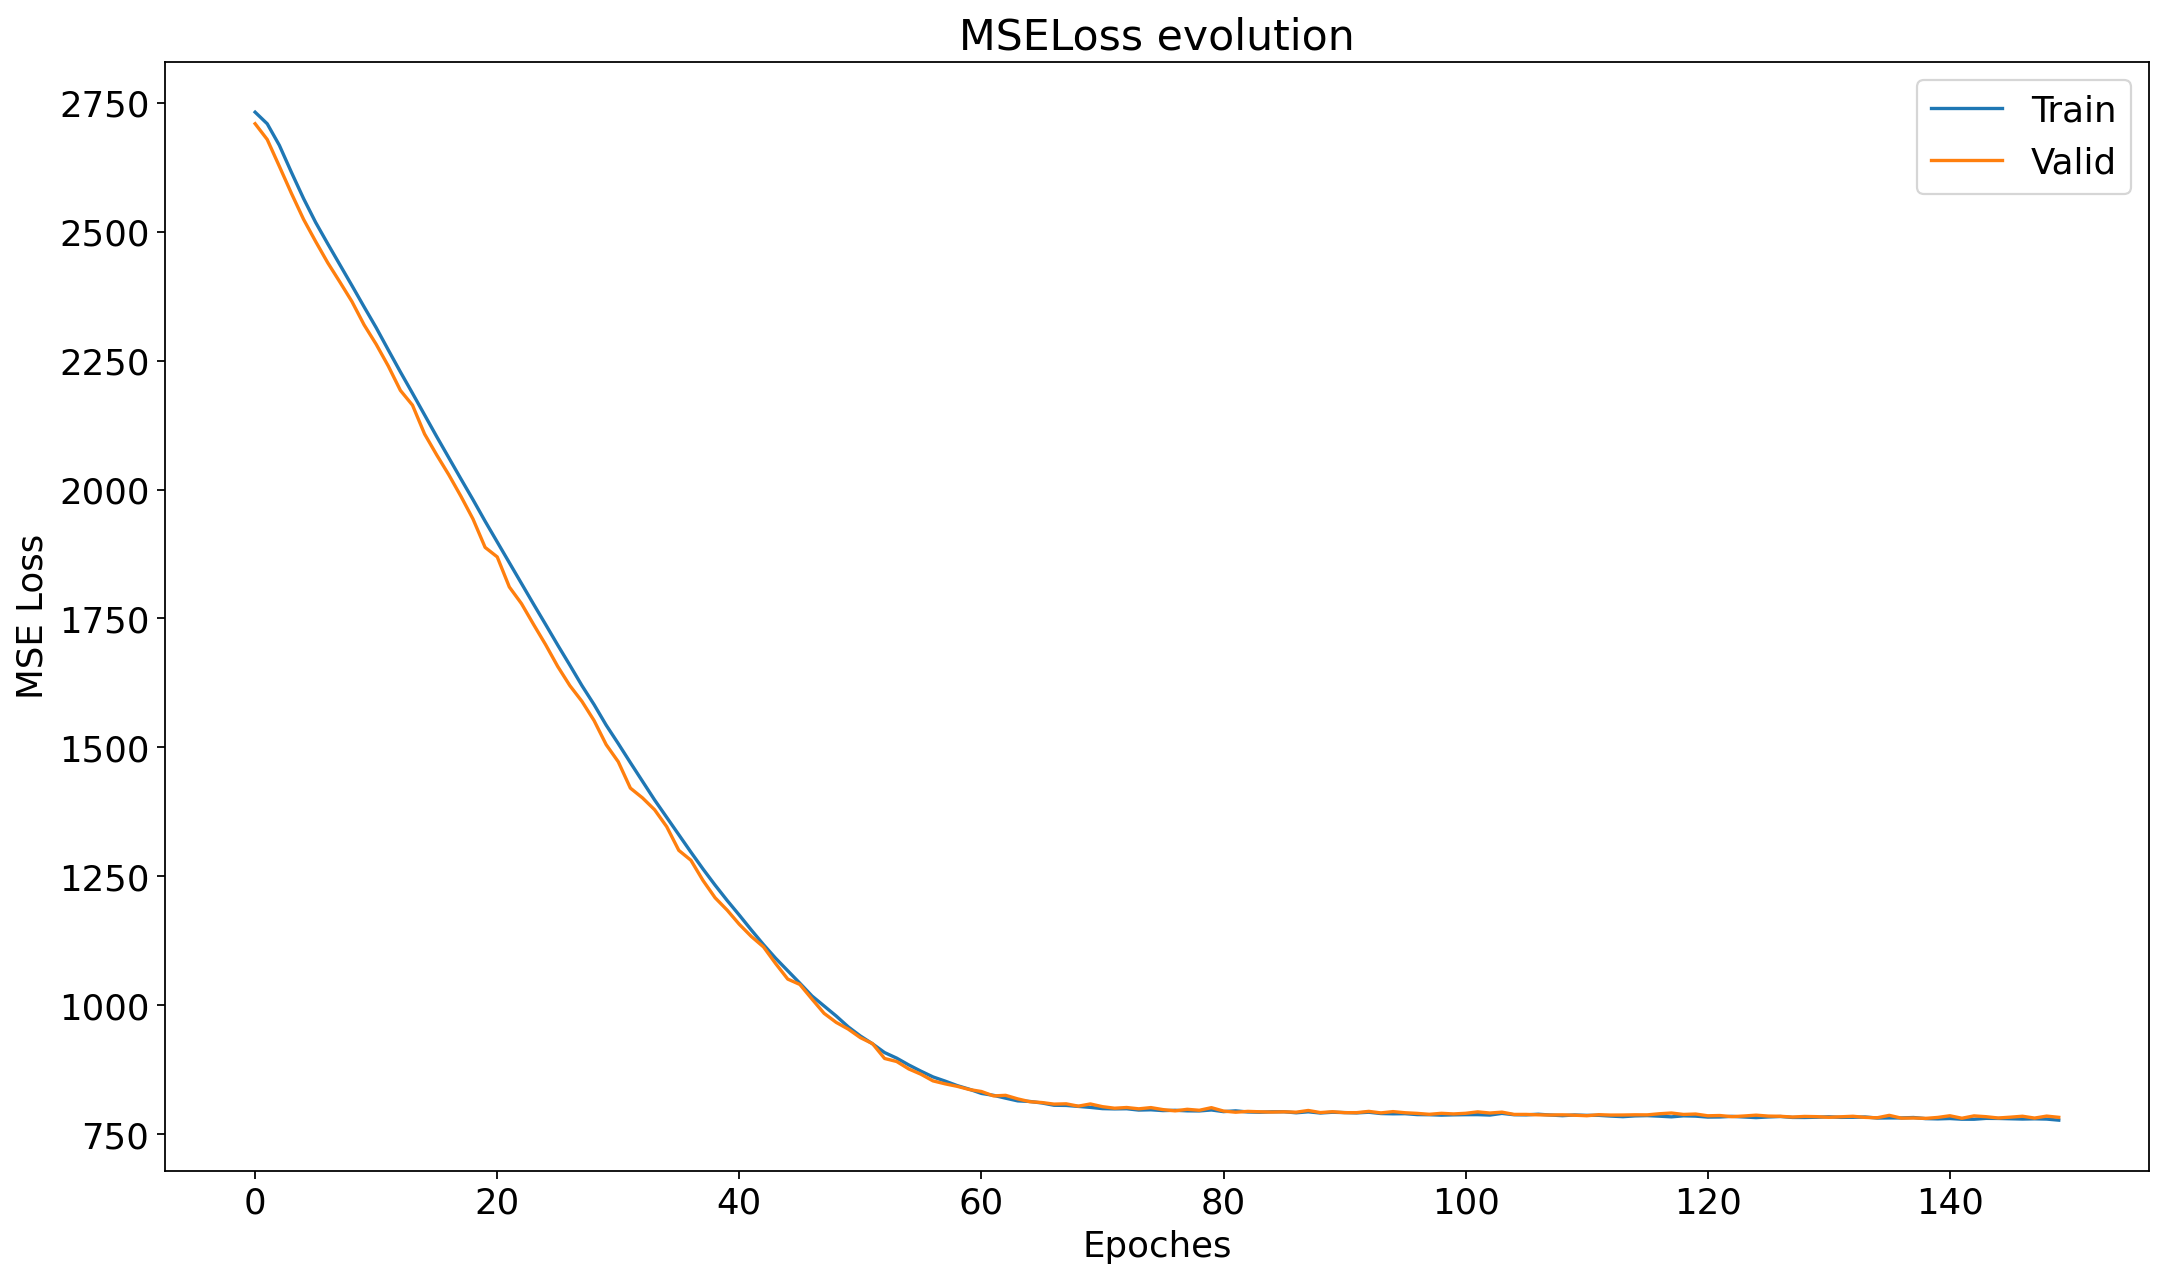

In [9]:
plt.figure(figsize = (16, 9), dpi = 160)
plt.rcParams.update({'font.size': 16})
plt.plot(train_loss, "-", label = "Train")
plt.plot(valid_loss, "-", label = "Valid")
plt.legend(loc=1)
plt.xlabel("Epoches")
plt.ylabel("MSE Loss")
plt.title(f"MSELoss evolution")

Text(0.5, 1.0, 'Annular mode prediction from EMF, *20')

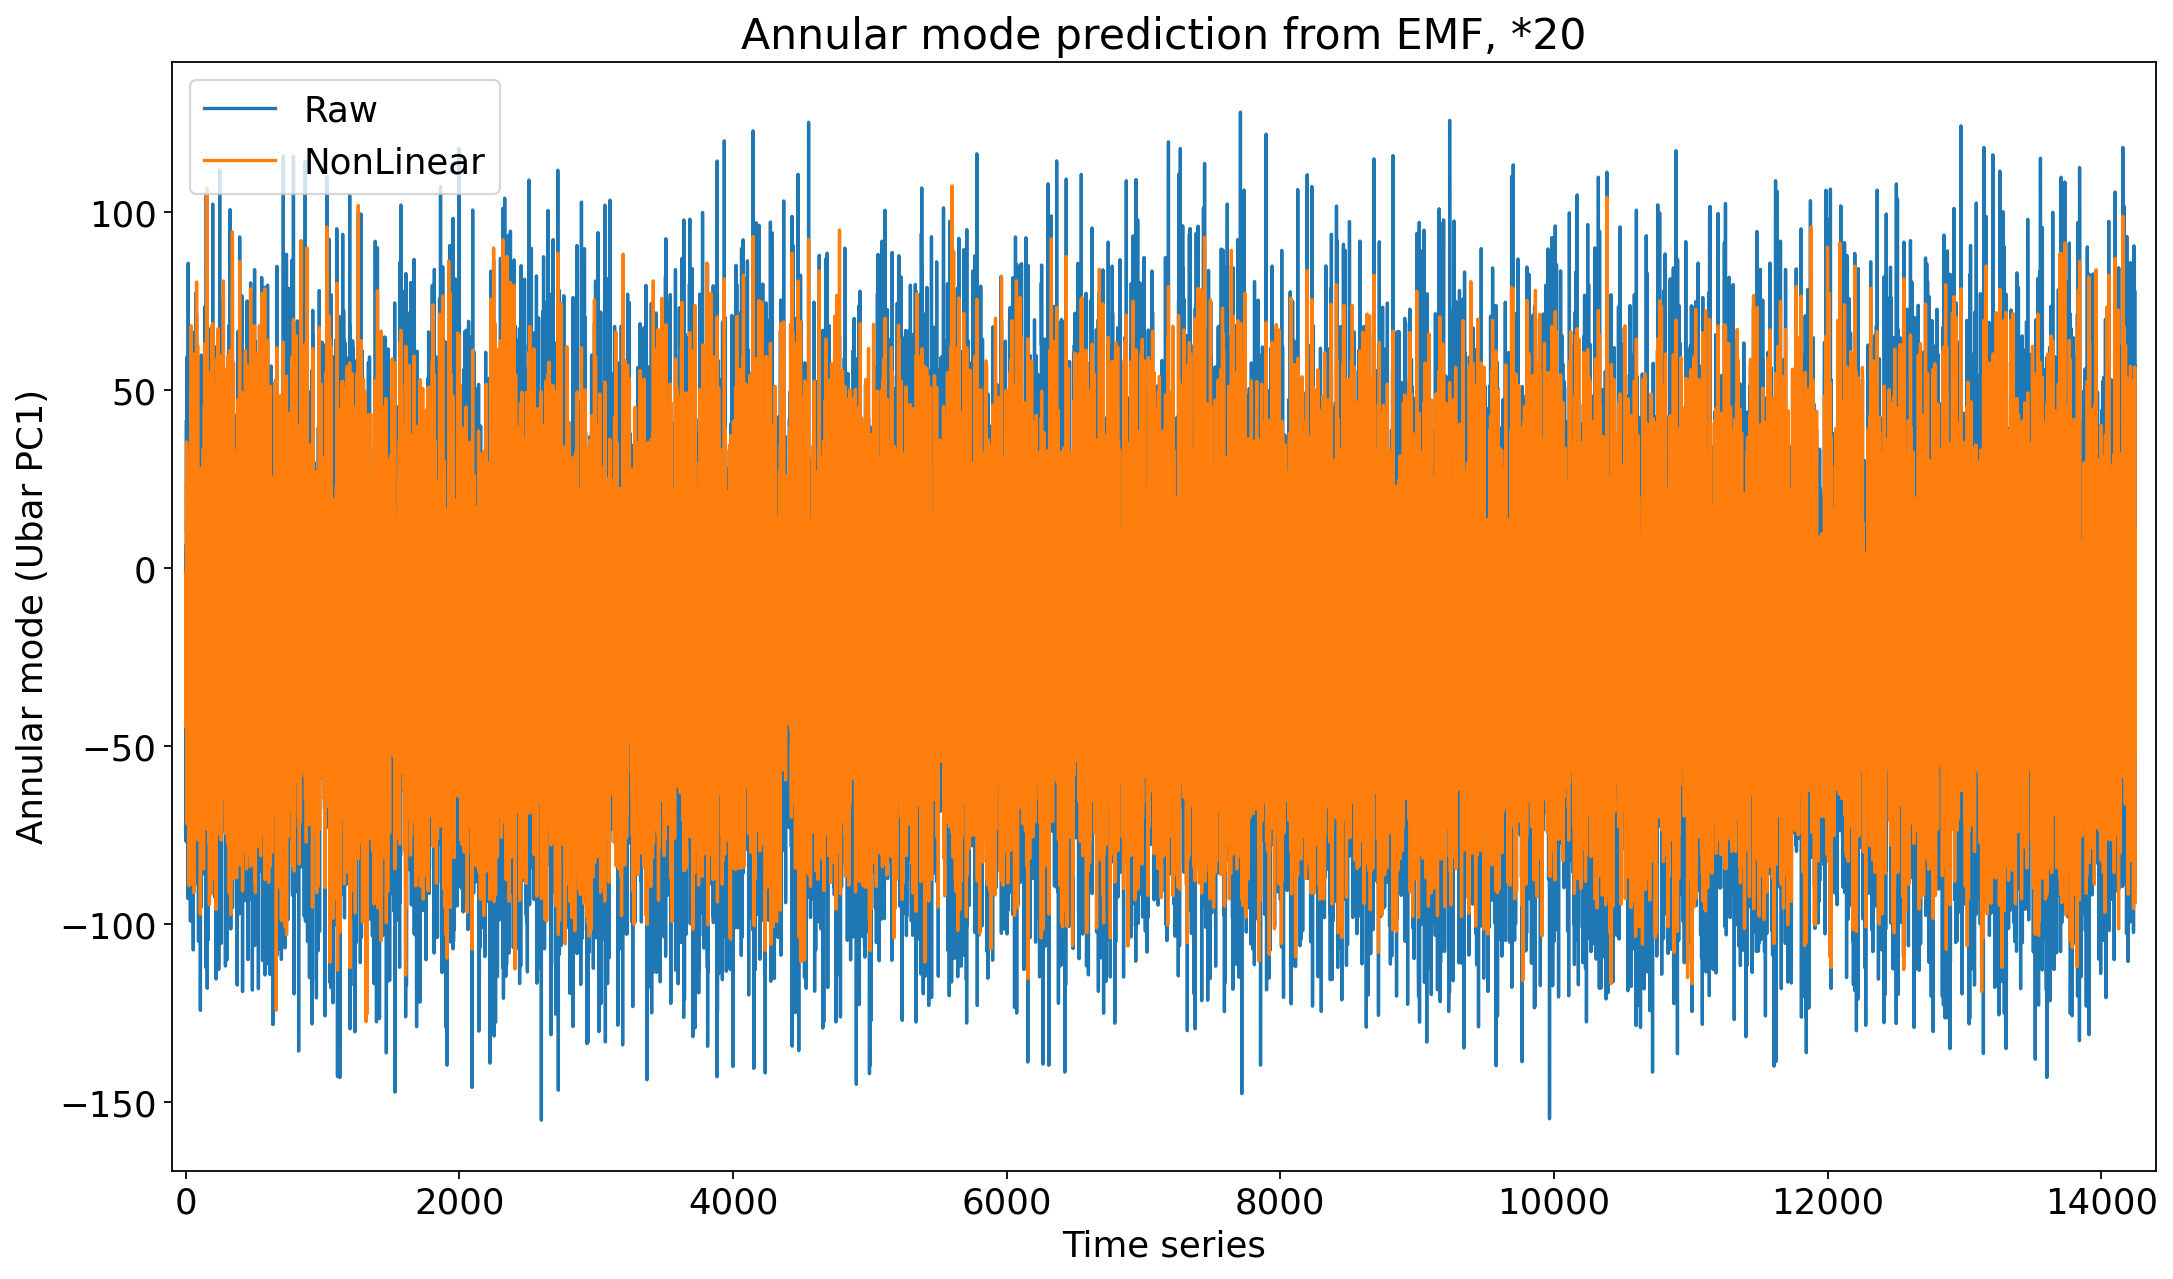

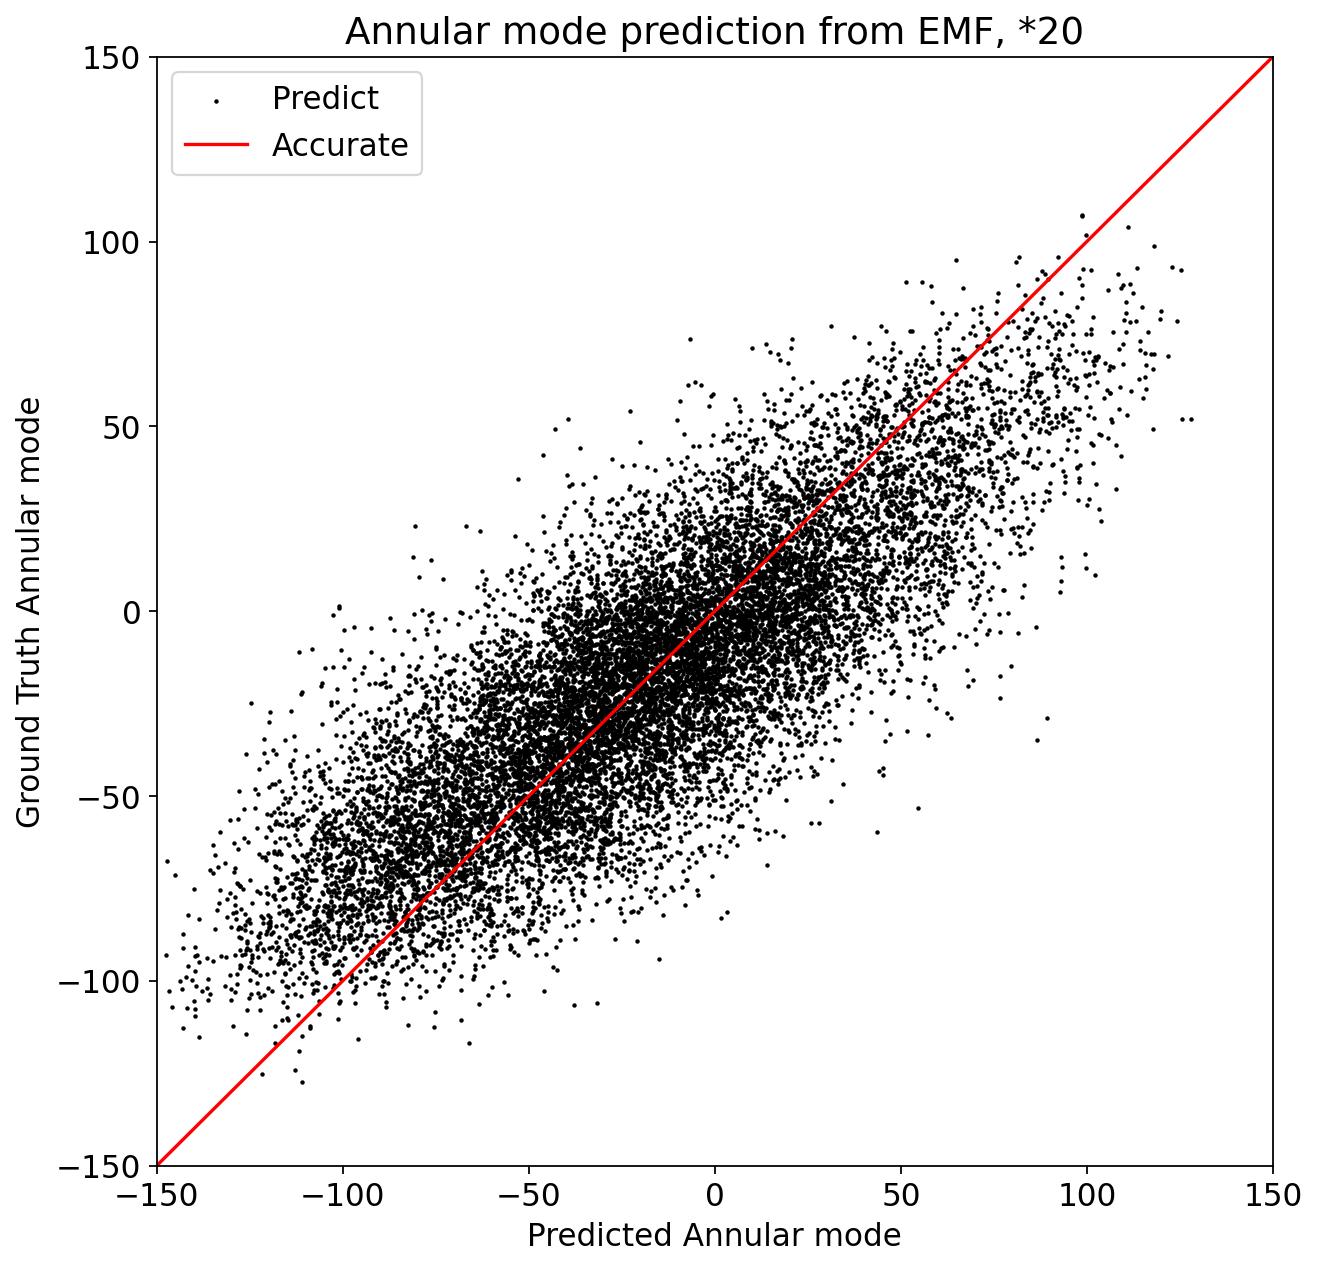

In [10]:
plt.figure(figsize = (16, 9), dpi = 160)
plt.rcParams.update({'font.size': 16})
plt.plot(ML_output_test_set[:,:1], "-", label = "Raw")
plt.plot(pred_data[:,:1], "-", label = "NonLinear")
plt.legend(loc=2)
plt.xlabel("Time series")
plt.ylabel("Annular mode (Ubar PC1)")
plt.xlim(-100,14400)
plt.title(f"Annular mode prediction from EMF, *{in_features}")

plt.figure(figsize = (9, 9), dpi = 160)
plt.rcParams.update({'font.size': 14})
plt.scatter(ML_output_test_set[:,:1], pred_data[:,:1], s = 1, color = "k", label = "Predict")
plt.plot([-200,200], [-200,200] , color = "r", label = "Accurate")
plt.legend(loc=2)
plt.xlabel("Predicted Annular mode")
plt.ylabel("Ground Truth Annular mode")
plt.xlim(-150,150)
plt.ylim(-150,150)
plt.title(f"Annular mode prediction from EMF, *{in_features}")

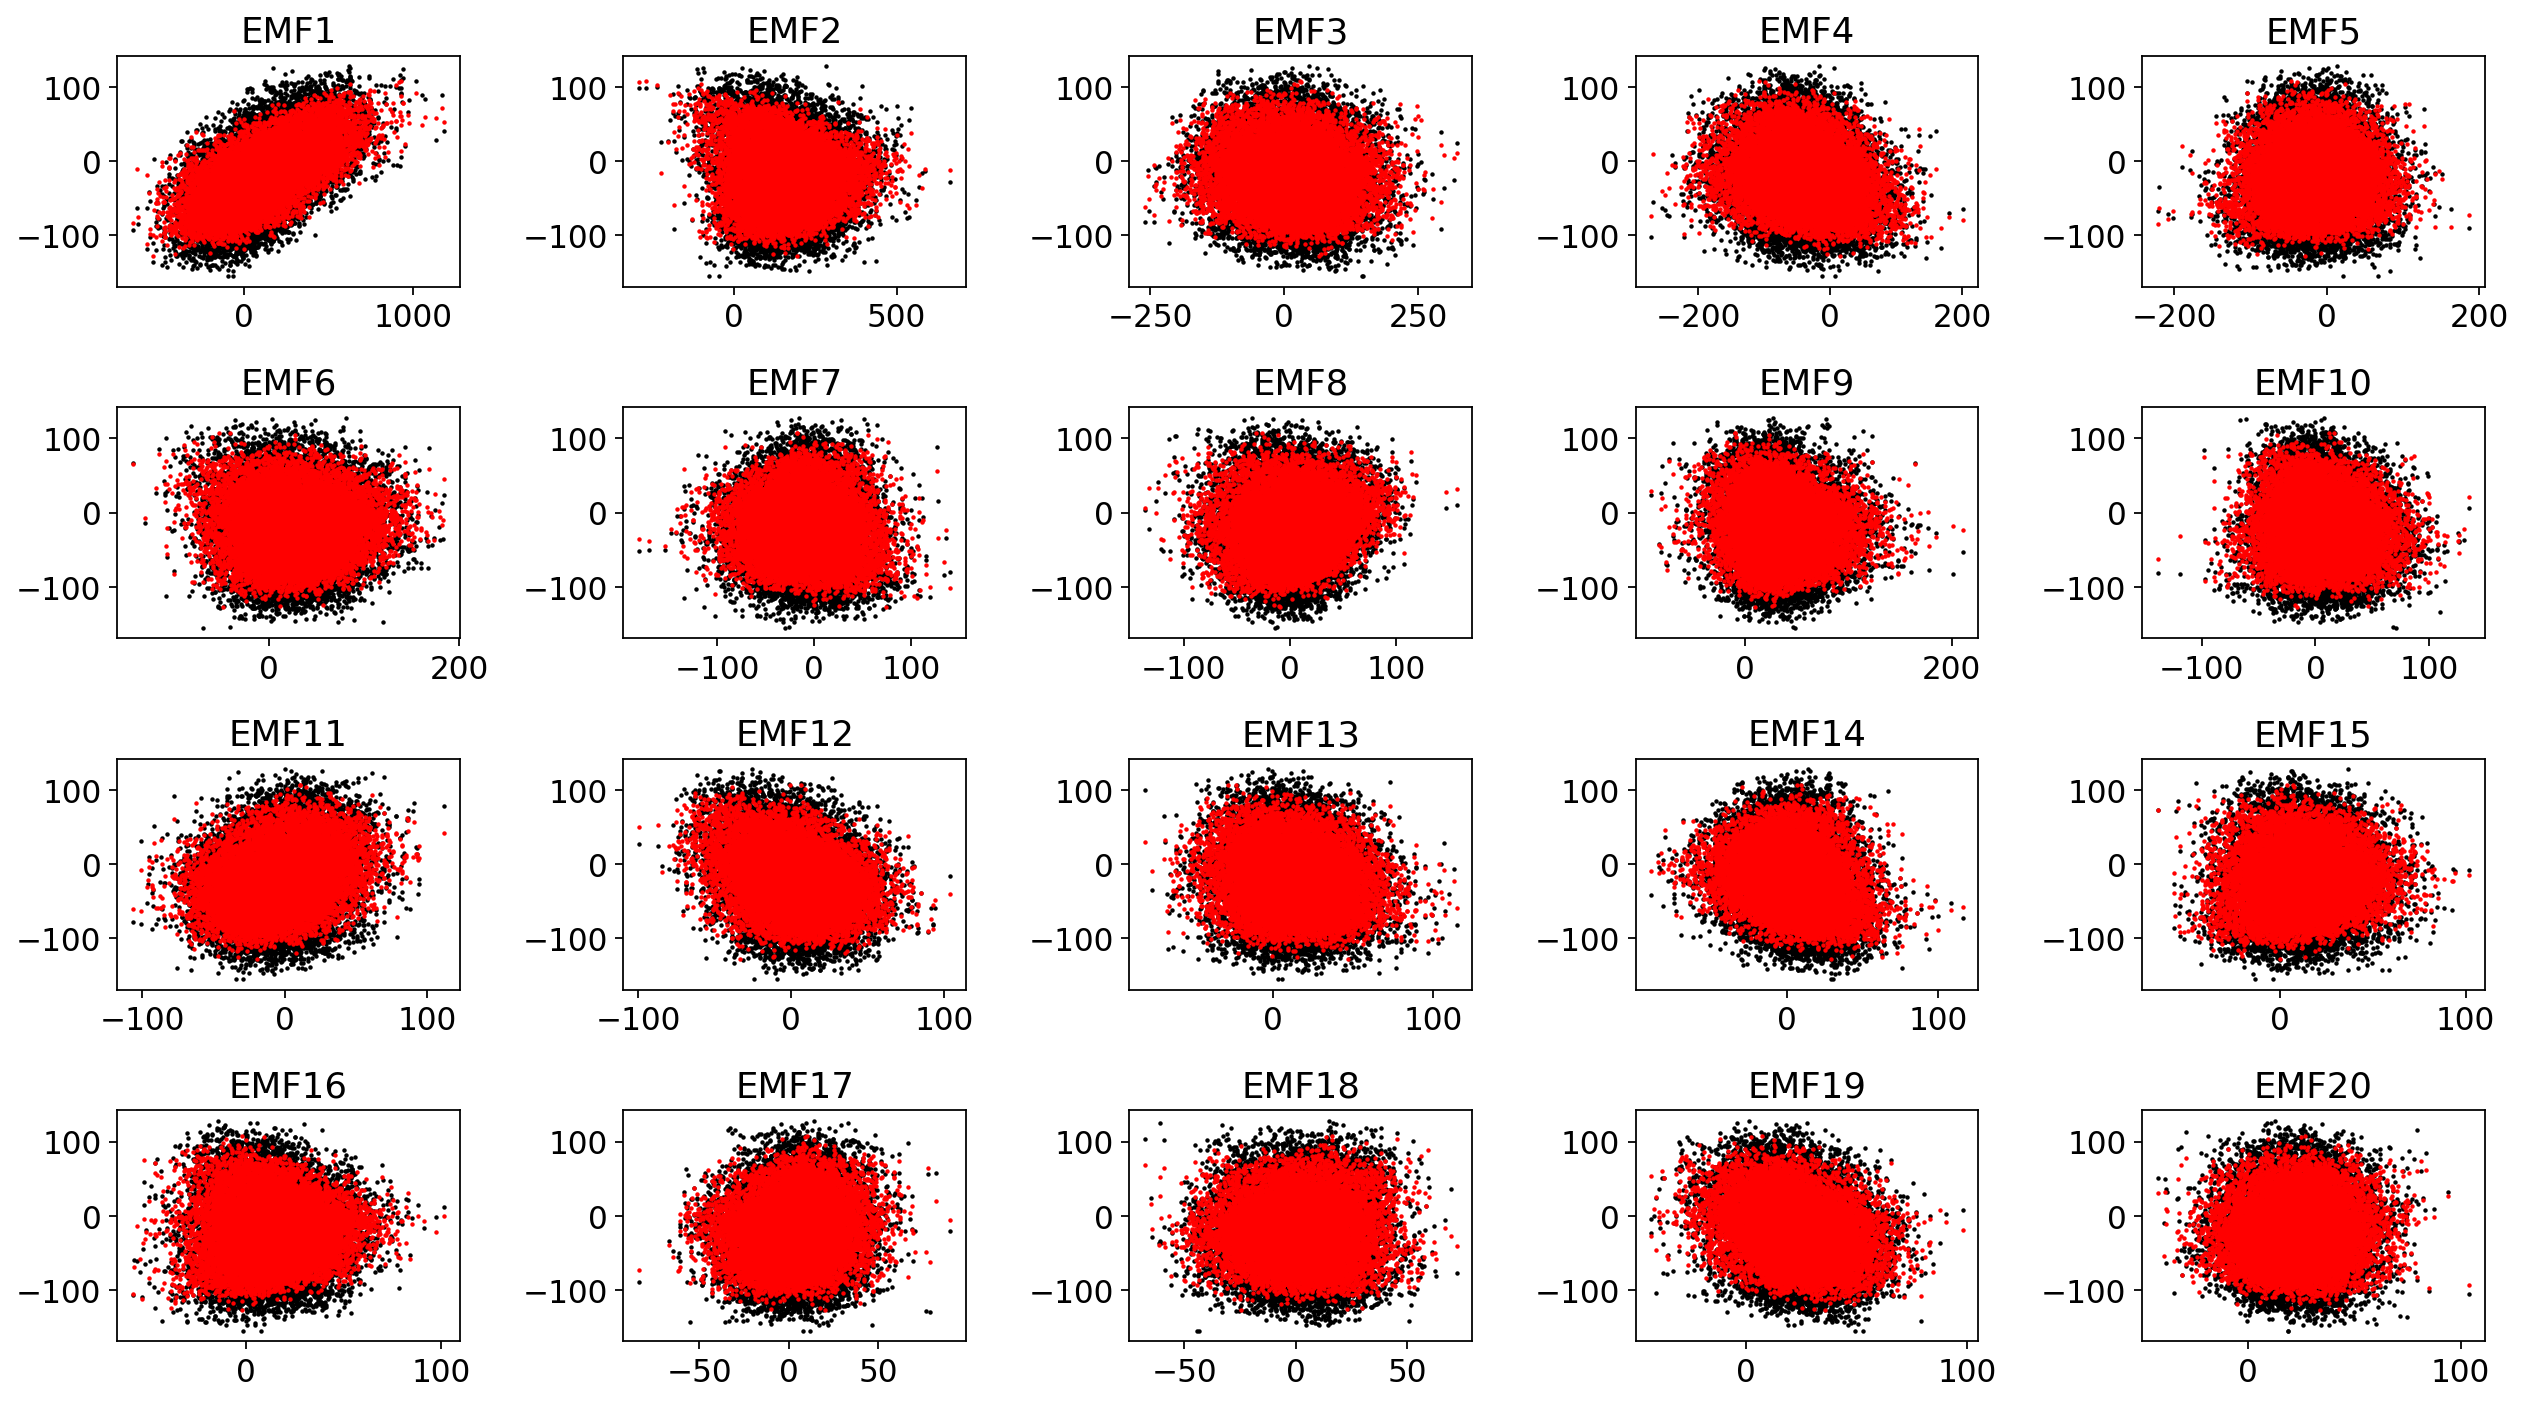

In [11]:
fig, axes = plt.subplots(nrows = 4, ncols = 5,
                         figsize = (16,9), dpi = 160)

for i,ax in enumerate(axes.flatten()):
    ax.scatter(ML_input_test_set[:,i], ML_output_test_set[:,0], s = 1, color = "k", label = "Predict")
    ax.scatter(ML_input_test_set[:,i], pred_data[:,0], s = 1, color = "r", label = "Predict")
    ax.set_title(f"EMF{i+1}", fontsize = 16)
plt.tight_layout()